In [1]:
# Import necessary libraries
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set team-specific information
RM =['Real-Madrid', '53a2f082']
FCB = ['Barcelona', '206d90db']
ATM = ['Atletico-Madrid', 'db3b9613']

team = RM[0]
team_id = RM[1]

# Define seasons of interest
seasons = ['2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024']

# List to store DataFrames for each season
merged_dfs = []

In [3]:
# Loop through each season
for season in seasons:
    # Construct the URL for the team's match logs on FBref
    url = "https://fbref.com/en/squads/"+team_id+"/"+season+"/matchlogs/c12/shooting/"+team+"-Match-Logs-La-Liga"
    
    # Retrieve and process data for the team
    for_team = pd.read_html(url, index_col=[0,1])[0]
    for_team.columns = for_team.columns.droplevel(0)
    for_team = for_team.iloc[:-1]
    for_team = for_team.to_csv("tempforteam.csv")
    time.sleep(3)
    for_team = pd.read_csv("tempforteam.csv")
    for_team.rename(columns={for_team.columns[0]: 'Date', for_team.columns[1]: 'Time'}, inplace=True)

    # Retrieve and process data for the opponents
    against_team = pd.read_html(url, index_col=[0,1])[1]
    against_team.columns = against_team.columns.droplevel(0)
    against_team = against_team.iloc[:-1]
    against_team = against_team.to_csv("tempagainstteam.csv")
    time.sleep(3)
    against_team = pd.read_csv("tempagainstteam.csv")
    against_team.rename(columns={against_team.columns[0]: 'Date', against_team.columns[1]: 'Time'}, inplace=True)

    # Merge the data for the team and opponents based on common columns
    merged_df = pd.merge(for_team, against_team, on=['Date', 'Round', 'Opponent'], how='inner', suffixes=('_for', '_against'))
    merged_df = merged_df[['Date', 'Round', 'Opponent', 'GF_for', 'GA_for', 'npvar1_for', 'npvar1_against']]
    merged_df['Season'] = season
    merged_dfs.append(merged_df)



# Concatenate all DataFrames for different seasons into a single DataFrame
df = pd.concat(merged_dfs, ignore_index=True)

# Add a 'Match' column to represent the match number
df['Match'] = df.index + 1

In [31]:
freq=10

# Calculate rolling averages for expected goals (var1) for and against the team
df['first_var'] = df['GF_for'].rolling(window=freq).mean()
df['second_var'] = df['npxG_for'].rolling(window=freq).mean()

# Sort the DataFrame by 'Season' and 'Match'
df = df.sort_values(by=['Season', 'Match'])

# Create a list of unique seasons
unique_seasons = df['Season'].unique()

# Create a list of tick positions based on the changes in the 'Season' column
tick_positions = [df[df['Season'] == season]['Match'].iloc[0] for season in unique_seasons]

# Round values in the DataFrame to two decimal places
df = df.round(2)

In [32]:
df

,Date,Round,Opponent,GF_for,GA_for,npxG_for,npxG_against,Season,Match,first_var,second_var
0,2019-08-17,Matchweek 1,Celta Vigo,3,1,2.1,1.6,2019-2020,1,NaN,NaN
1,2019-08-24,Matchweek 2,Valladolid,1,1,1.7,1.2,2019-2020,2,NaN,NaN
2,2019-09-01,Matchweek 3,Villarreal,2,2,1.9,1.4,2019-2020,3,NaN,NaN
3,2019-09-14,Matchweek 4,Levante,3,2,2.9,1.2,2019-2020,4,NaN,NaN
4,2019-09-22,Matchweek 5,Sevilla,1,0,1.2,0.5,2019-2020,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
162,2023-10-28,Matchweek 11,Barcelona,2,1,1.1,1.5,2023-2024,163,2.1,1.77
163,2023-11-05,Matchweek 12,Rayo Vallecano,0,0,2.2,0.1,2023-2024,164,1.8,1.79
164,2023-11-11,Matchweek 13,Valencia,5,1,1.7,1.7,2023-2024,165,2.2,1.90
165,2023-11-26,Matchweek 14,Cádiz,3,0,1.6,1.2,2023-2024,166,2.3,1.78


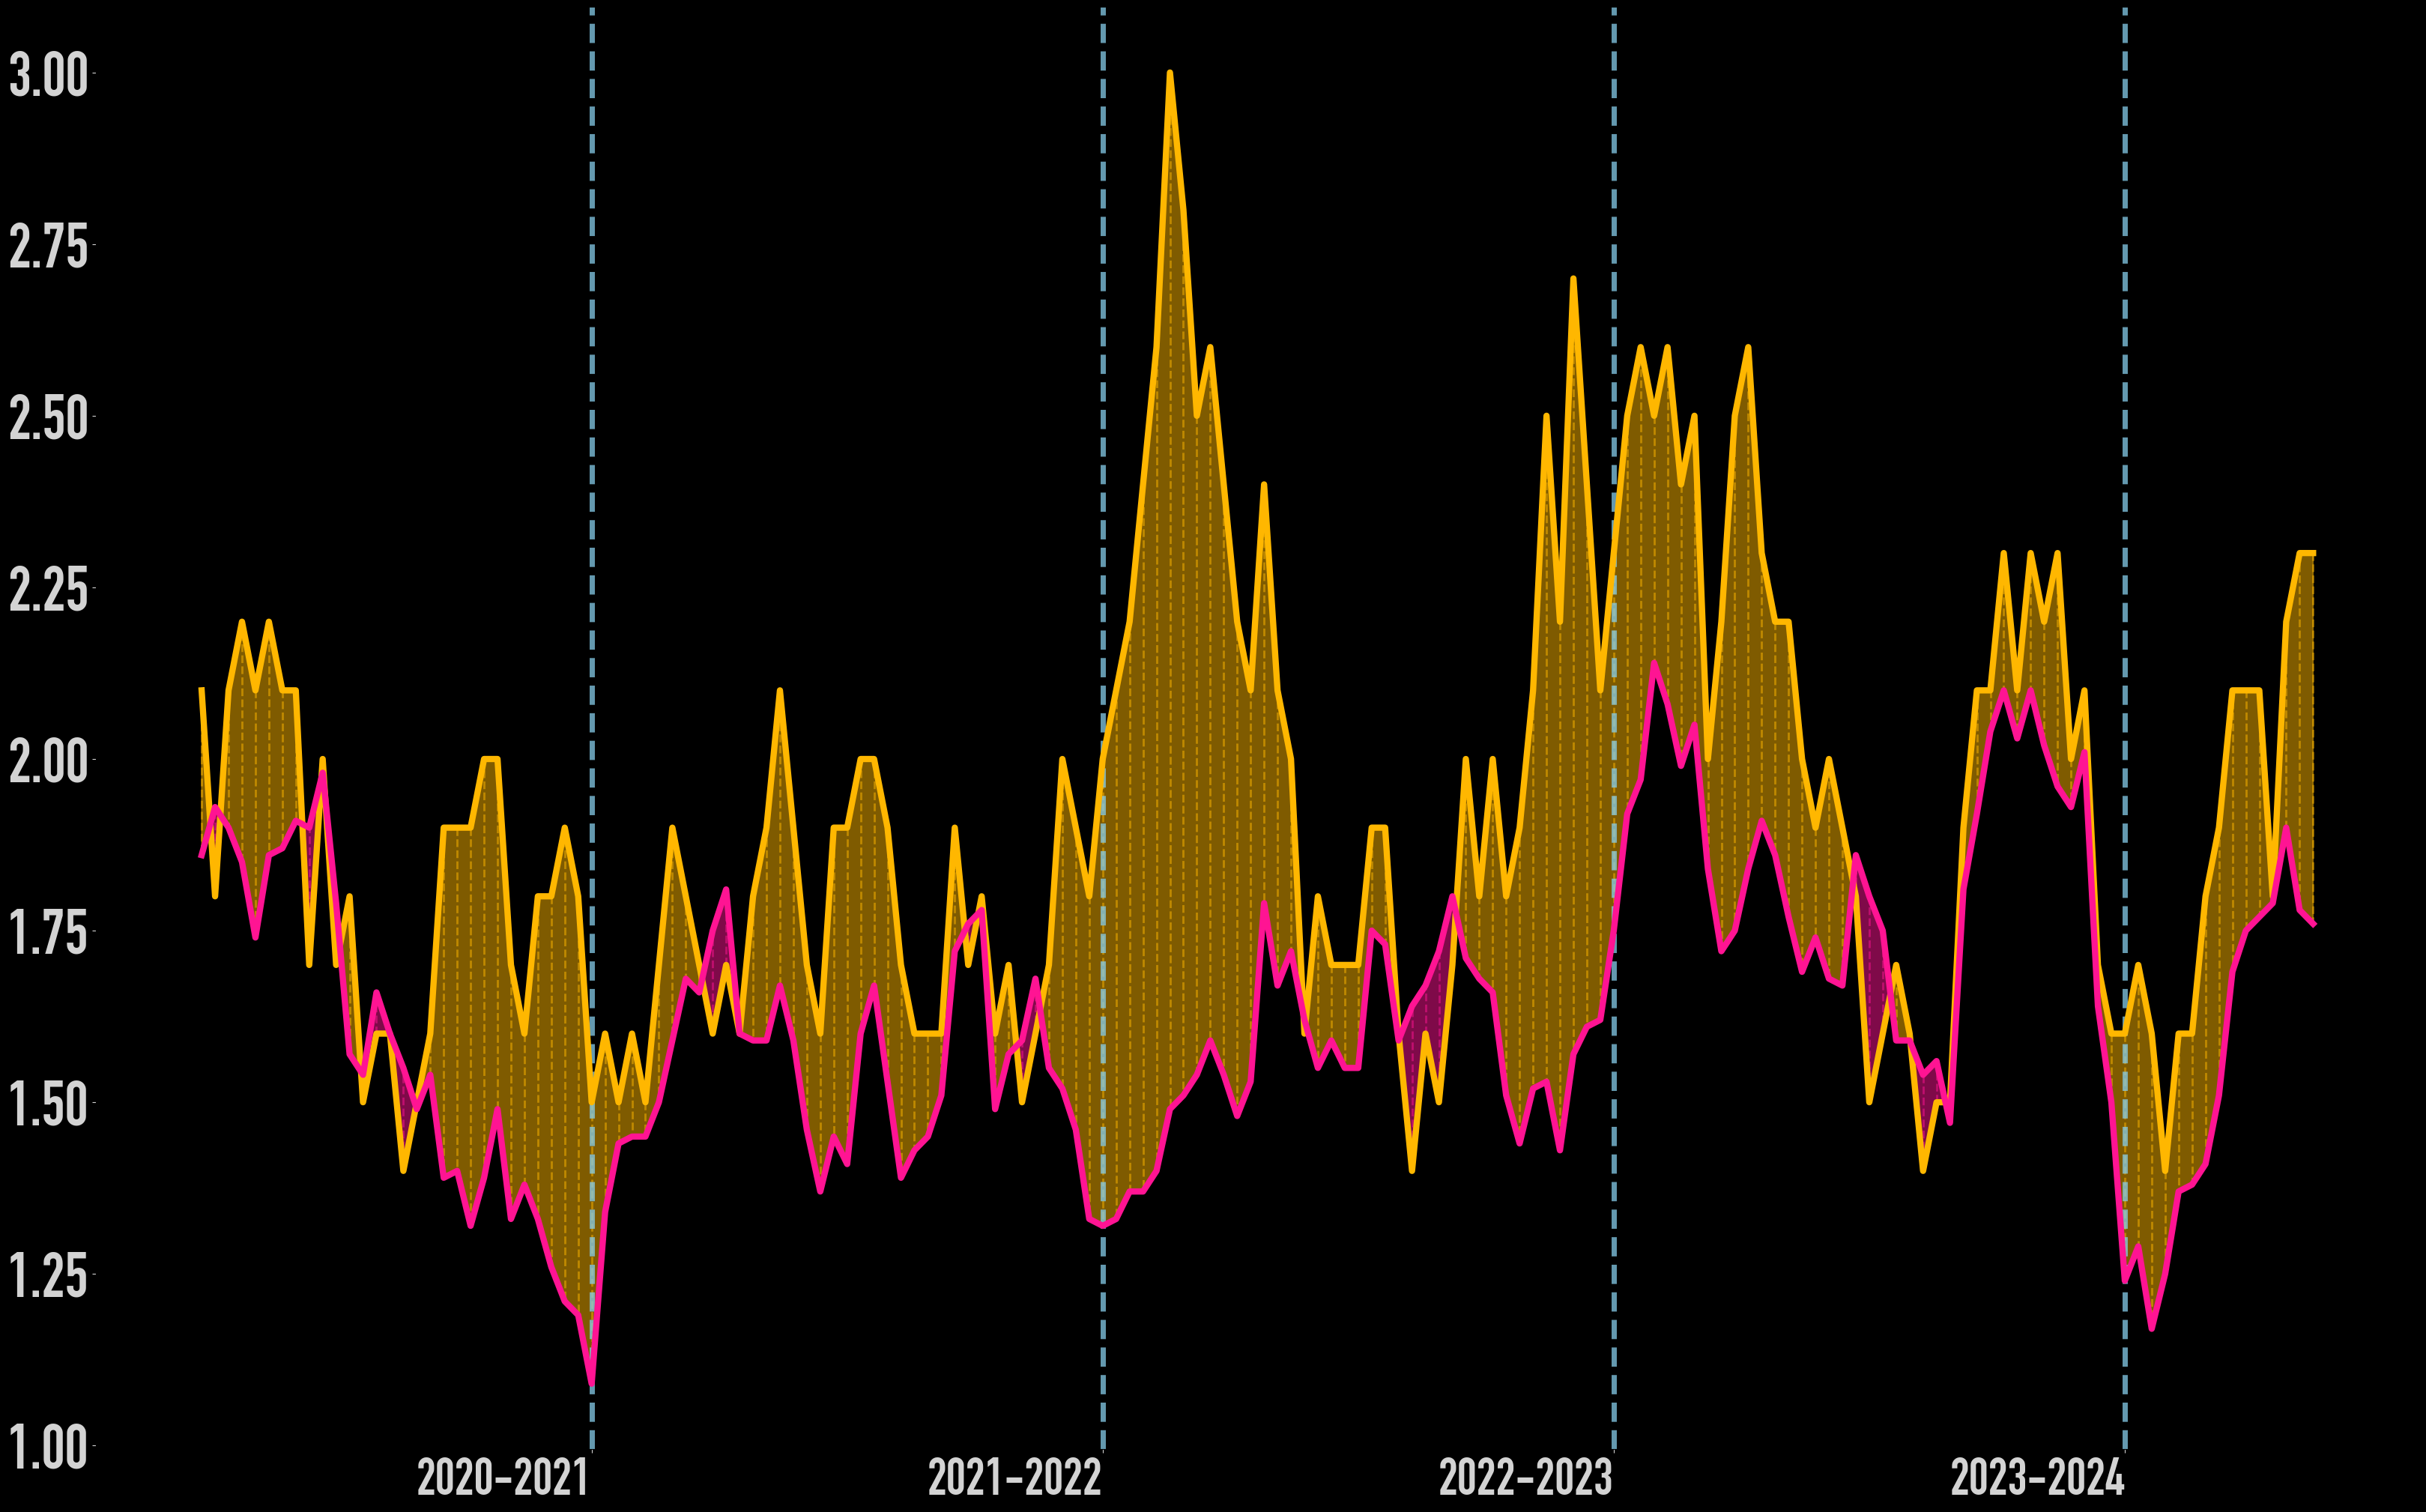

In [33]:
#Define colors for plotting
season_divider_clr = 'skyblue'
clr1 = '#ffb700'
clr2 = 'deeppink'
connector_clr = 'grey'

# Create a large black background figure for the plot
fig = plt.figure(figsize=(40, 25), facecolor='black')
ax = plt.axes()
ax.set_facecolor("black")

# Add grid lines for seasons with a specific color
ax.xaxis.grid(color=season_divider_clr, linestyle='--', linewidth=5, alpha=.75, zorder=1, label = 'Season Change')

# Set the x-axis ticks at the specified positions
plt.xticks(tick_positions, unique_seasons, ha='right', fontsize=50, color='lightgrey')

ax.tick_params(axis='x', colors='lightgrey')
ax.tick_params(axis='y', colors='lightgrey')

# Customize matplotlib parameters for better visualization
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['font.size'] = 60
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.linewidth'] = '6'
plt.rcParams['font.family'] = 'DIN Condensed'

# Plot the rolling averages for var1 and var2
plt.plot(df.Match, df.first_var, color=clr1)
plt.plot(df.Match, df.second_var, color=clr2)

## Plot connecting lines between var1 and var2 for each match
for index, row in df.iterrows():
    match = row['Match']
    var1 = row['first_var']
    var2 = row['second_var']

    if var1 > var2:
        plt.plot([match, match], [var1, var2], color=clr1, linestyle='--', linewidth=2, alpha=.5, zorder=1)
    elif var2 > var1:
        plt.plot([match, match], [var1, var2], color=clr2, linestyle='--', linewidth=2, alpha=.5, zorder=1)
        
        
# Fill the area between xG and xGA
plt.fill_between(df.Match, df.first_var, df.second_var, where=df.first_var > df.second_var, interpolate=True, color=clr1, alpha=0.5)
plt.fill_between(df.Match, df.first_var, df.second_var, where=df.second_var > df.first_var, interpolate=True, color=clr2, alpha=0.5)


# Customize the legend
#plt.legend(['var1', 'var2'], loc='upper center', fontsize='large', facecolor='w', edgecolor='white', framealpha=0.8)

# Save the plot as an image file
plt.savefig(team + '-Rollingvar1'+str(freq)+'.png', bbox_inches='tight')